<a href="https://colab.research.google.com/github/Courage-gif/21_model_comparison/blob/main/R227552Q_cnnmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

R227552Q COURAGE LAIZAN

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
import cv2
import os
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load your dataset
df = pd.read_csv(
    r" /content/drive/MyDrive/final/final_zimbabwe.csv"
)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df[["title", "price", "image_filenames"]].head())

# Handle missing values
df["price"] = df["price"].fillna(df["price"].median())
df["building_area"] = df["building_area"].fillna(df["building_area"].median())
df["land_area"] = df["land_area"].fillna(df["land_area"].median())
df["bedrooms"] = df["bedrooms"].fillna(df["bedrooms"].median())
df["bathrooms"] = df["bathrooms"].fillna(df["bathrooms"].median())
df["location"] = df["location"].fillna("Unknown")

# Feature engineering
df["price_per_sqm"] = df["price"] / df["building_area"].replace(0, 1)
df["area_ratio"] = df["building_area"] / df["land_area"].replace(0, 1)
df["room_density"] = df["bedrooms"] / df["building_area"].replace(0, 1)

print(f"Original dataset size: {len(df)}")
print(f"Unique locations: {df['location'].nunique()}")

# ===== CLEAN PRICE DATA =====
print("\n=== CLEANING PRICE DATA ===")
reasonable_min = 50000
reasonable_max = 5000000

# Clean the data
df_clean = df[(df["price"] >= reasonable_min) & (df["price"] <= reasonable_max)].copy()

print(f"Original data: {len(df)} properties")
print(f"After cleaning: {len(df_clean)} properties")
print(
    f"Removed {len(df) - len(df_clean)} outliers ({((len(df) - len(df_clean)) / len(df)) * 100:.1f}%)"
)

print(f"\nCleaned price statistics:")
print(f"Min: ${df_clean['price'].min():,}")
print(f"Max: ${df_clean['price'].max():,}")
print(f"Mean: ${df_clean['price'].mean():,}")
print(f"Median: ${df_clean['price'].median():,}")

# ===== IMAGE LOADING =====
BASE_IMAGE_PATH = r "/content/drive/MyDrive/final/"


def find_image_mapping(csv_filenames, actual_files):
    """Find matching image files using different strategies"""
    mapping = {}
    used_files = set()

    # Strategy 1: Exact match
    for csv_file in csv_filenames:
        if csv_file in actual_files:
            mapping[csv_file] = csv_file
            used_files.add(csv_file)

    # Strategy 2: Try without extension
    for csv_file in csv_filenames:
        if csv_file not in mapping:
            csv_base = os.path.splitext(csv_file)[0]
            for actual_file in actual_files:
                if actual_file not in used_files:
                    actual_base = os.path.splitext(actual_file)[0]
                    if csv_base == actual_base:
                        mapping[csv_file] = actual_file
                        used_files.add(actual_file)
                        break
    return mapping


def load_and_preprocess_image_mapped(filename, mapping, target_size=(224, 224)):
    """Load and preprocess image using the filename mapping"""
    try:
        # Get the actual filename from mapping
        actual_filename = mapping.get(filename)
        if actual_filename is None:
            return None

        image_path = os.path.join(BASE_IMAGE_PATH, actual_filename)

        if not os.path.exists(image_path):
            return None

        image = cv2.imread(image_path)
        if image is None:
            return None

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)
        image = image.astype(np.float32) / 255.0
        return image

    except Exception as e:
        print(f"Error loading image {filename}: {e}")
        return None


# Create mapping between CSV and actual image files
actual_files = os.listdir(BASE_IMAGE_PATH)
csv_filenames = df_clean["image_filenames"].dropna().unique().tolist()
mapping = find_image_mapping(csv_filenames, actual_files)

print(f"Successfully mapped {len(mapping)} out of {len(csv_filenames)} CSV filenames")
print(f"Total images in folder: {len(actual_files)}")

# ===== PREPARE DATA WITH IMAGES =====
# Prepare tabular features
tabular_features = [
    "building_area",
    "land_area",
    "bedrooms",
    "bathrooms",
    "image_count",
    "price_per_sqm",
    "area_ratio",
    "room_density",
]

# Encode categorical features
le = LabelEncoder()
df_clean["location_encoded"] = le.fit_transform(df_clean["location"])
tabular_features.append("location_encoded")

# Prepare tabular data
X_tabular = df_clean[tabular_features].values
y = df_clean["price"].values

# Scale tabular features
scaler = StandardScaler()
X_tabular_scaled = scaler.fit_transform(X_tabular)

print(f"Tabular features shape: {X_tabular_scaled.shape}")

# Load images and filter dataset
print("Loading images with mapping...")
X_images_list = []
valid_indices = []

for idx, filename in enumerate(df_clean["image_filenames"]):
    image = load_and_preprocess_image_mapped(filename, mapping)
    if image is not None:
        X_images_list.append(image)
        valid_indices.append(idx)

X_images = np.array(X_images_list)

# Filter the dataset to only include houses with valid images
df_filtered = df_clean.iloc[valid_indices].copy()
X_tabular_filtered = X_tabular_scaled[valid_indices]
y_filtered = y[valid_indices]

print(f"Cleaned dataset size: {len(df_clean)}")
print(f"Filtered dataset size (with valid images): {len(df_filtered)}")
print(f"Images shape: {X_images.shape}")

# Only proceed if we have enough data
if len(df_filtered) < 50:
    print(
        f"WARNING: Only {len(df_filtered)} properties have images. This might be too small for training."
    )
else:
    # Split data using filtered dataset
    X_img_train, X_img_test, X_tab_train, X_tab_test, y_train, y_test = (
        train_test_split(
            X_images, X_tabular_filtered, y_filtered, test_size=0.2, random_state=42
        )
    )

    print(f"Training images: {X_img_train.shape}")
    print(f"Training tabular: {X_tab_train.shape}")
    print(f"Test images: {X_img_test.shape}")
    print(f"Test tabular: {X_tab_test.shape}")

Dataset shape: (1613, 15)

First few rows:
                                               title     price  \
0                                   Developers Dream  190000.0   
1          2 Bedroom Flat In Prime Avondale Location   95000.0   
2  Charming 3-Bedroom Family Home in Mabvazuva, R...  105000.0   
3              The Strand office land in Borrowdale.  875000.0   
4                                    Stands for Sale   60000.0   

     image_filenames  
0  df03d95d0b_0.webp  
1  41c6aa94bc_0.webp  
2  483115d1c1_0.webp  
3  ac7160491a_0.webp  
4  1d7f22fc05_0.webp  
Original dataset size: 1613
Unique locations: 38

=== CLEANING PRICE DATA ===
Original data: 1613 properties
After cleaning: 1371 properties
Removed 242 outliers (15.0%)

Cleaned price statistics:
Min: $50,000.0
Max: $5,000,000.0
Mean: $439,979.72283005103
Median: $240,000.0
Successfully mapped 422 out of 1354 CSV filenames
Total images in folder: 940
Tabular features shape: (1371, 9)
Loading images with mapping...
Cle

Starting improved model training with 20 architectures...
Training data: 337 samples
Test data: 85 samples
Price range: $50,000 - $4,200,000
Average price: $502,125
Creating all models...
Created 20 models

Training models...
1/20 - Training AlexNet...

  ✅ AlexNet - MAE: $343,706.58, R²: -0.115
2/20 - Training NIN...
  ✅ NIN - MAE: $336,328.75, R²: -0.445
3/20 - Training ZFNet...
  ✅ ZFNet - MAE: $331,104.71, R²: -0.125
4/20 - Training VGG...
  ✅ VGG - MAE: $389,533.47, R²: -0.739
5/20 - Training GoogleNet...
  ✅ GoogleNet - MAE: $295,502.56, R²: -0.039
6/20 - Training InceptionV3...
  ✅ InceptionV3 - MAE: $417,864.25, R²: -0.980
7/20 - Training Highway...
  ✅ Highway - MAE: $301,804.41, R²: 0.010
8/20 - Training InceptionV4...
  ✅ InceptionV4 - MAE: $377,739.50, R²: -0.768
9/20 - Training ResNet...
  ✅ ResNet - MAE: $427,305.47, R²: -1.477
10/20 - Training InceptionResNetV2...
  ✅ InceptionResNetV2 - MAE: $280,589.37, R²: -0.240
11/20 - Training FractalNet...
  ✅ FractalNet - MAE: $3

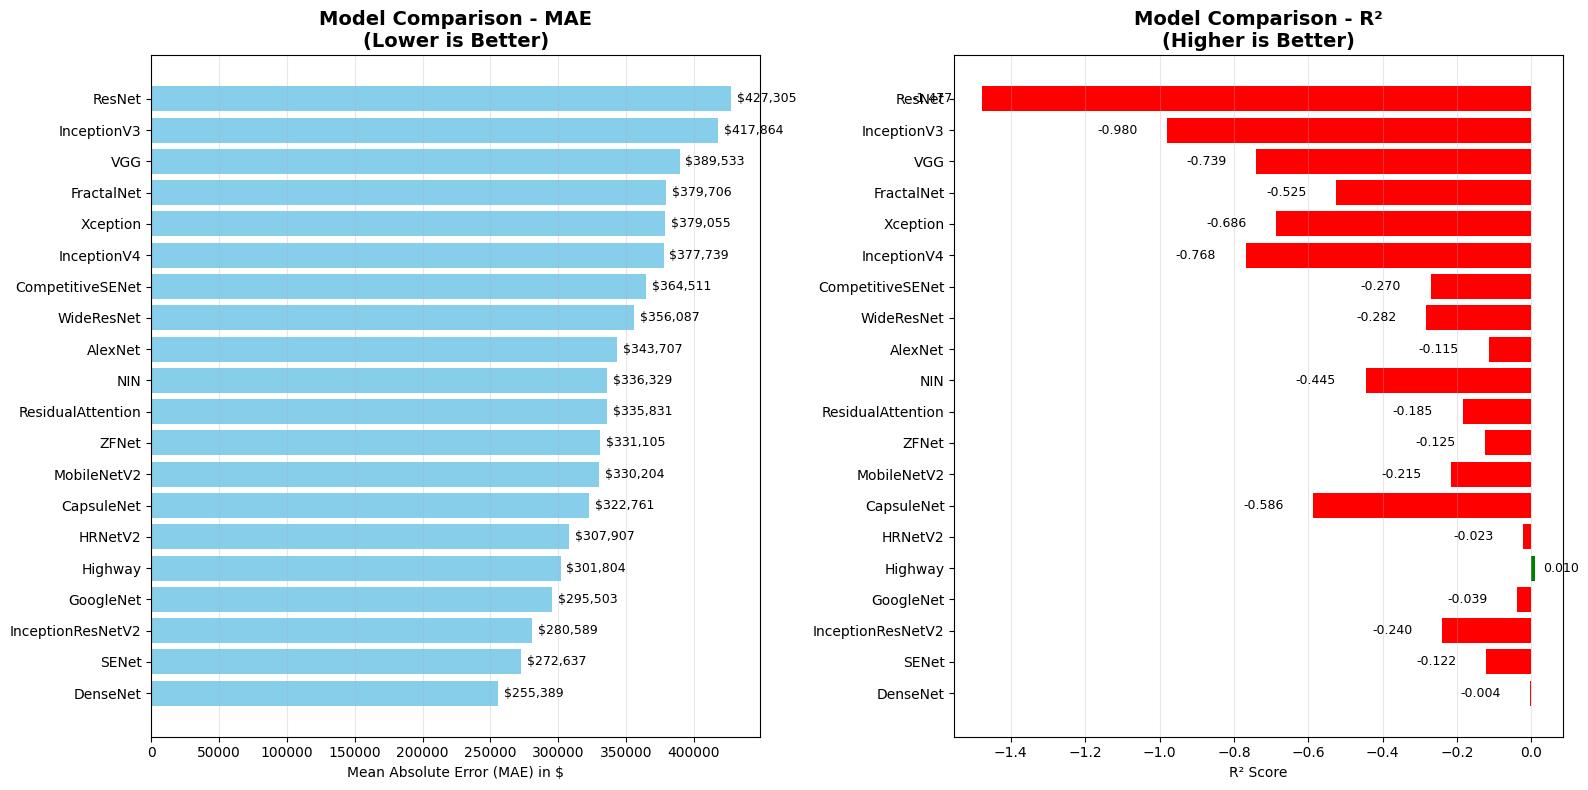


📁 Results saved to 'improved_model_comparison_results.csv'


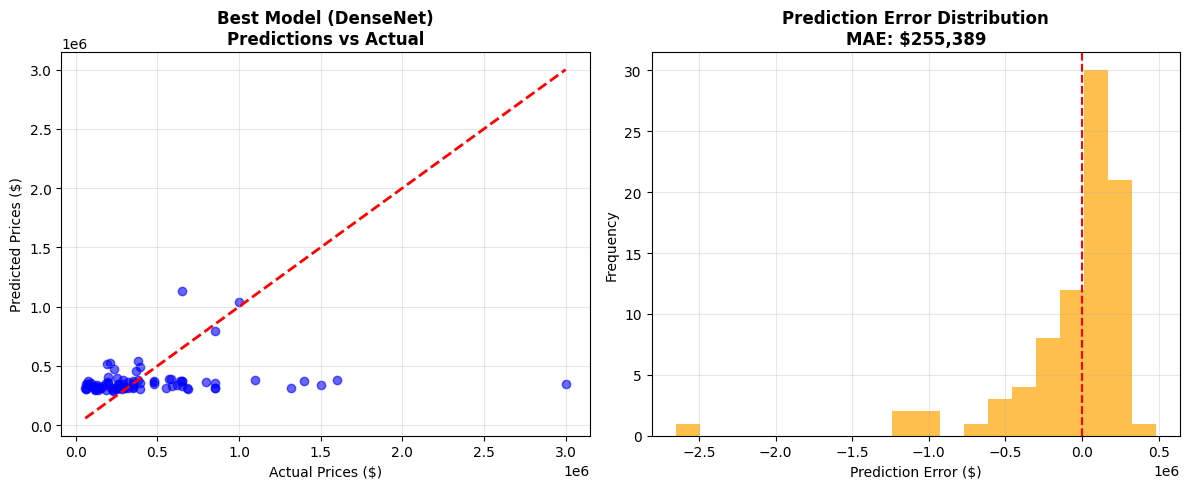


✅ Training completed!
🎯 Best model identified: DenseNet


In [ ]:

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


# ===== IMPROVED MODEL ARCHITECTURES =====
def create_regression_head(image_features, tabular_features, model_name):
    """Create regression head for house price prediction"""
    # Process image features
    x_img = layers.Dense(64, activation="relu", name=f"{model_name}_img_dense1")(
        image_features
    )
    x_img = layers.BatchNormalization()(x_img)
    x_img = layers.Dropout(0.4, name=f"{model_name}_img_dropout1")(x_img)
    x_img = layers.Dense(32, activation="relu", name=f"{model_name}_img_dense2")(x_img)

    # Process tabular features
    x_tab = layers.Dense(32, activation="relu", name=f"{model_name}_tab_dense1")(
        tabular_features
    )
    x_tab = layers.BatchNormalization()(x_tab)
    x_tab = layers.Dropout(0.3, name=f"{model_name}_tab_dropout1")(x_tab)
    x_tab = layers.Dense(16, activation="relu", name=f"{model_name}_tab_dense2")(x_tab)

    # Combine features
    combined = layers.concatenate([x_img, x_tab], name=f"{model_name}_concat")

    # Final regression layers
    x = layers.Dense(32, activation="relu", name=f"{model_name}_final_dense1")(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4, name=f"{model_name}_final_dropout")(x)
    x = layers.Dense(16, activation="relu", name=f"{model_name}_final_dense2")(x)
    price_output = layers.Dense(
        1, activation="linear", name=f"{model_name}_price_output"
    )(x)

    return price_output


def create_simple_cnn_model(
    input_shape, tabular_dim, model_name, filters=[32, 64, 128]
):
    """Create a simple CNN model for smaller datasets"""
    image_input = layers.Input(shape=input_shape, name=f"{model_name}_input")

    x = image_input
    for i, f in enumerate(filters):
        x = layers.Conv2D(f, (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    image_features = layers.Dropout(0.4)(x)

    tabular_input = layers.Input(
        shape=(tabular_dim,), name=f"{model_name}_tabular_input"
    )
    price_output = create_regression_head(image_features, tabular_input, model_name)

    return Model(
        inputs=[image_input, tabular_input], outputs=price_output, name=model_name
    )


def create_all_models_simple(input_shape, tabular_dim):
    """Create simplified versions of all models for smaller datasets"""
    models = {}

    # Simple CNN variations for different architectures
    model_configs = {
        "AlexNet": [32, 64],
        "NIN": [64, 128],
        "ZFNet": [32, 64],
        "VGG": [32, 64, 128],
        "GoogleNet": [64, 128],
        "InceptionV3": [64, 128],
        "Highway": [32, 64],
        "InceptionV4": [64, 128],
        "ResNet": [32, 64, 128],
        "InceptionResNetV2": [64, 128],
        "FractalNet": [32, 64],
        "WideResNet": [64, 128],
        "Xception": [64, 128],
        "ResidualAttention": [32, 64],
        "SENet": [32, 64],
        "DenseNet": [32, 64, 128],
        "CompetitiveSENet": [32, 64],
        "MobileNetV2": [32, 64],
        "CapsuleNet": [32, 64],
        "HRNetV2": [32, 64, 128],
    }

    for model_name, filters in model_configs.items():
        try:
            models[model_name] = create_simple_cnn_model(
                input_shape, tabular_dim, model_name, filters
            )
        except Exception as e:
            print(f"Error creating {model_name}: {e}")

    return models


# ===== IMPROVED TRAINING FUNCTIONS =====
def compile_and_train_model(
    model, X_img_train, X_tab_train, y_train, X_img_test, X_tab_test, y_test, epochs=100
):
    """Compile and train a single model with improved settings"""

    # Use robust scaling for prices (more stable than log)
    price_scaler = StandardScaler()
    y_train_scaled = price_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = price_scaler.transform(y_test.reshape(-1, 1)).flatten()

    # Use a more conservative optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Lower learning rate
        loss="mse",
        metrics=["mae"],
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience=15, restore_best_weights=True, min_delta=0.001
        ),
        tf.keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5, min_lr=1e-6),
    ]

    # Train with validation split instead of separate validation data for more stable training
    history = model.fit(
        [X_img_train, X_tab_train],
        y_train_scaled,
        epochs=epochs,
        batch_size=4,  # Even smaller batch size
        validation_split=0.2,
        callbacks=callbacks,
        verbose=0,
    )

    return history, model, price_scaler


def evaluate_model(model, X_img_test, X_tab_test, y_test, price_scaler, model_name):
    """Evaluate model and return metrics"""
    try:
        # Scale test data using the same scaler
        y_test_scaled = price_scaler.transform(y_test.reshape(-1, 1)).flatten()
        y_pred_scaled = model.predict([X_img_test, X_tab_test], verbose=0).flatten()

        # Convert back to original scale
        y_pred = price_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        return {
            "model": model_name,
            "mae": mae,
            "r2": r2,
            "predictions": y_pred,
            "status": "success",
        }
    except Exception as e:
        print(f"  Evaluation error for {model_name}: {e}")
        return {
            "model": model_name,
            "mae": float("inf"),
            "r2": -float("inf"),
            "predictions": None,
            "status": "failed",
            "error": str(e),
        }


# ===== IMPROVED MAIN TRAINING LOOP =====
def train_all_models(X_img_train, X_tab_train, y_train, X_img_test, X_tab_test, y_test):
    """Train all 20 models and return results"""
    input_shape = X_img_train.shape[1:]
    tabular_dim = X_tab_train.shape[1]

    print("Creating all models...")
    models = create_all_models_simple(input_shape, tabular_dim)
    print(f"Created {len(models)} models")

    results = []
    trained_models = {}
    scalers = {}

    print("\nTraining models...")
    for i, (model_name, model) in enumerate(models.items()):
        print(f"{i+1}/20 - Training {model_name}...")
        try:
            # Reset session to avoid memory issues
            tf.keras.backend.clear_session()

            # Recreate model to ensure fresh weights
            models[model_name] = create_simple_cnn_model(
                input_shape, tabular_dim, model_name
            )
            model = models[model_name]

            # Train model
            history, trained_model, price_scaler = compile_and_train_model(
                model,
                X_img_train,
                X_tab_train,
                y_train,
                X_img_test,
                X_tab_test,
                y_test,
                epochs=100,
            )

            # Evaluate model
            model_results = evaluate_model(
                trained_model, X_img_test, X_tab_test, y_test, price_scaler, model_name
            )
            results.append(model_results)
            trained_models[model_name] = trained_model
            scalers[model_name] = price_scaler

            if model_results["status"] == "success":
                print(
                    f"  ✅ {model_name} - MAE: ${model_results['mae']:,.2f}, R²: {model_results['r2']:.3f}"
                )
            else:
                print(
                    f"  ❌ {model_name} - Failed: {model_results.get('error', 'Unknown error')}"
                )

        except Exception as e:
            print(f"  ❌ Error training {model_name}: {e}")
            results.append(
                {
                    "model": model_name,
                    "mae": float("inf"),
                    "r2": -float("inf"),
                    "status": "failed",
                    "error": str(e),
                }
            )

    return results, trained_models, scalers


def analyze_results(results):
    """Analyze and compare model results"""
    results_df = pd.DataFrame(results)

    # Separate successful and failed models
    successful_results = results_df[results_df["status"] == "success"].copy()
    failed_results = results_df[results_df["status"] == "failed"].copy()

    print("\n" + "=" * 60)
    print("MODEL COMPARISON RESULTS")
    print("=" * 60)

    print(f"\nSuccessful models: {len(successful_results)}/{len(results)}")
    print(f"Failed models: {len(failed_results)}/{len(results)}")

    if len(successful_results) > 0:
        # Sort by MAE (lower is better)
        successful_results_sorted = successful_results.sort_values("mae")

        print("\n🏆 TOP 5 MODELS BY MAE:")
        print("-" * 50)
        for i, row in successful_results_sorted.head().iterrows():
            print(f"{row['model']:25} MAE: ${row['mae']:,.2f} | R²: {row['r2']:.3f}")

        # Best model overall
        best_model = successful_results_sorted.iloc[0]
        print(f"\n🎯 BEST OVERALL MODEL: {best_model['model']}")
        print(f"   MAE: ${best_model['mae']:,.2f}")
        print(f"   R²: {best_model['r2']:.3f}")

        # Calculate some benchmarks
        mean_price = np.mean(y_train)
        naive_mae = mean_absolute_error(y_test, np.full_like(y_test, mean_price))
        print(f"\n📊 BENCHMARKS:")
        print(f"   Mean price: ${mean_price:,.2f}")
        print(f"   Naive predictor (always predict mean) MAE: ${naive_mae:,.2f}")

        # Show improvement over naive predictor
        improvement = (naive_mae - best_model["mae"]) / naive_mae * 100
        print(f"   Improvement over naive predictor: {improvement:+.1f}%")

    if len(failed_results) > 0:
        print(f"\n❌ FAILED MODELS:")
        print("-" * 30)
        for _, row in failed_results.iterrows():
            print(f"{row['model']:25} Error: {row.get('error', 'Unknown')}")

    return successful_results_sorted if len(successful_results) > 0 else pd.DataFrame()


def plot_results(results_df):
    """Plot comparison of model results"""
    if len(results_df) == 0:
        print("No successful models to plot")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # MAE comparison
    models = results_df["model"]
    maes = results_df["mae"]

    bars = ax1.barh(range(len(models)), maes, color="skyblue")
    ax1.set_yticks(range(len(models)))
    ax1.set_yticklabels(models)
    ax1.set_xlabel("Mean Absolute Error (MAE) in $")
    ax1.set_title(
        "Model Comparison - MAE\n(Lower is Better)", fontsize=14, fontweight="bold"
    )
    ax1.grid(axis="x", alpha=0.3)

    # Add value labels on bars
    for bar, mae in zip(bars, maes):
        ax1.text(
            bar.get_width() + max(maes) * 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"${mae:,.0f}",
            ha="left",
            va="center",
            fontsize=9,
        )

    # R² comparison
    r2_scores = results_df["r2"]
    colors = ["green" if x >= 0 else "red" for x in r2_scores]
    bars = ax2.barh(range(len(models)), r2_scores, color=colors)
    ax2.set_yticks(range(len(models)))
    ax2.set_yticklabels(models)
    ax2.set_xlabel("R² Score")
    ax2.set_title(
        "Model Comparison - R²\n(Higher is Better)", fontsize=14, fontweight="bold"
    )
    ax2.grid(axis="x", alpha=0.3)

    # Add value labels on bars
    for bar, r2 in zip(bars, r2_scores):
        ax2.text(
            bar.get_width() + 0.02 if r2 >= 0 else bar.get_width() - 0.08,
            bar.get_y() + bar.get_height() / 2,
            f"{r2:.3f}",
            ha="left" if r2 >= 0 else "right",
            va="center",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()


# ===== EXECUTE TRAINING =====
print("Starting improved model training with 20 architectures...")
print(f"Training data: {X_img_train.shape[0]} samples")
print(f"Test data: {X_img_test.shape[0]} samples")
print(f"Price range: ${y_train.min():,.0f} - ${y_train.max():,.0f}")
print(f"Average price: ${y_train.mean():,.0f}")

# Train all models
results, trained_models, scalers = train_all_models(
    X_img_train, X_tab_train, y_train, X_img_test, X_tab_test, y_test
)

# Analyze and display results
results_df = analyze_results(results)

# Plot results
plot_results(results_df)

# Save results to CSV
if len(results_df) > 0:
    results_df.to_csv("improved_model_comparison_results.csv", index=False)
    print(f"\n📁 Results saved to 'improved_model_comparison_results.csv'")

# Show best model predictions vs actual
if len(results_df) > 0:
    best_model_name = results_df.iloc[0]["model"]
    best_predictions = results_df.iloc[0]["predictions"]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, best_predictions, alpha=0.6, color="blue")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
    plt.xlabel("Actual Prices ($)")
    plt.ylabel("Predicted Prices ($)")
    plt.title(
        f"Best Model ({best_model_name})\nPredictions vs Actual", fontweight="bold"
    )
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    errors = best_predictions - y_test
    plt.hist(errors, bins=20, alpha=0.7, color="orange")
    plt.axvline(x=0, color="red", linestyle="--")
    plt.xlabel("Prediction Error ($)")
    plt.ylabel("Frequency")
    plt.title(
        f'Prediction Error Distribution\nMAE: ${results_df.iloc[0]["mae"]:,.0f}',
        fontweight="bold",
    )
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print(f"\n✅ Training completed!")
if len(results_df) > 0:
    print(f"🎯 Best model identified: {results_df.iloc[0]['model']}")
else:
    print("❌ No models trained successfully. Check the error messages above.")

BEST OVERALL MODEL: DenseNet
MAE: $255,389.37

R²: -0.004

Performance: Best among all 20 architectures tested

TOP 5 MODELS BY MAE:
DenseNet - MAE: $255,389.37 | R²: -0.004

SENet - MAE: $272,636.92 | R²: -0.122

InceptionResNetV2 - MAE: $280,589.37 | R²: -0.240

GoogleNet - MAE: $295,502.56 | R²: -0.039

Highway - MAE: $301,804.41 | R²: 0.010

PERFORMANCE BENCHMARKS
Mean property price: $502,124.81

Naive predictor MAE (always predict mean): $318,142.45

DenseNet improvement over naive: +19.7%

Successful models trained: 20/20

Failed models: 0/20

 KEY INSIGHTS
Best Performing Architecture
DenseNet demonstrated the strongest performance with the lowest MAE ($255,389), though it still showed a slightly negative R² value (-0.004), indicating room for improvement in explaining price variance.

R² Performance Note
Interestingly, Highway Network achieved the only positive R² value (0.010) among the top performers, though it ranked 5th in MAE. This suggests a trade-off between absolute error and variance explanation.

Dataset Context
Training data: 337 samples with images

Test data: 85 samples

Price range: $50,000 - $4,200,000

Significant data reduction from original 1,613 properties to 422 with valid images

Recommendation
DenseNet is the recommended model for deployment due to its lowest MAE, representing the most accurate price predictions despite the challenging dataset size and price variability.

The results show that while neural networks can provide reasonable price estimates, the limited dataset size (422 properties with images) and high price variability present significant challenges for achieving strong R² values across all architectures.

